In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('EDMDB'))

#### Dataframe Setup

In [4]:
df = pd.read_sql_query('''SELECT * FROM dcp.pluto201 WHERE ownertype IS NOT NULL;''', cnx)
df = df[["bbl", "ownertype", "ownername", "geom", "assesstot", "exempttot", "bldgclass", "landuse"]]
df.head()

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
0,3.025080e+09,C,NYC DEPARTMENT OF SANITATION,0106000020D70800000200000001030000000100000008...,14411700.0,14411700.0,Y6,07
1,2.053090e+09,C,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000010...,0.0,0.0,V0,11
2,3.077430e+09,X,LIRR,0106000020D7080000010000000103000000010000000E...,0.0,0.0,U6,07
3,2.048720e+09,X,UNITED AUTUMN INC,0106000020D70800000100000001030000000100000006...,0.0,0.0,C0,02
4,1.019680e+09,X,NYC HOUSING PRESERVATION AND DEVELOPMENT,0106000020D70800000100000001030000000100000005...,637200.0,637200.0,C1,02


In [5]:
bldgclass_def = pd.read_sql_query('''SELECT * FROM dcp.bldgclass_definitions;''', cnx)
landuse_def = pd.read_sql_query('''SELECT * FROM dcp.landuse_definitions;''', cnx)

Create a dataframe of normalized owner names

In [6]:
ownername_df = pd.read_sql_query('''SELECT * FROM dcp.ownernames;''', cnx)
ownername_df.head()

,bbl,field,old_value,new_value,type,reason,version
0,None,ownername,PORT AUTHORITY,PORT AUTHORITY OF NY AND NJ,1,Normalized owner name,19v2
1,None,ownername,PORT AUTHORITY NY & NJ,PORT AUTHORITY OF NY AND NJ,1,Normalized owner name,19v2
2,None,ownername,PORT OF NEW YORK AUTHORITY,PORT AUTHORITY OF NY AND NJ,1,Normalized owner name,19v2
3,None,ownername,PORT OF NEW YORK AUTH,PORT AUTHORITY OF NY AND NJ,1,Normalized owner name,19v2
4,None,ownername,PORT AUTH OF NY&NJ,PORT AUTHORITY OF NY AND NJ,1,Normalized owner name,19v2


#### OwnerType distribution

Distribution by owner type, including bar chart

In [7]:
type_counts = df['ownertype'].value_counts()
type(type_counts)
type_counts
df_dist = pd.DataFrame({'ownertype':type_counts.index, 'count':type_counts.values})
df_dist

,ownertype,count
0,X,17299
1,C,11505
2,O,1356
3,P,513
4,M,78


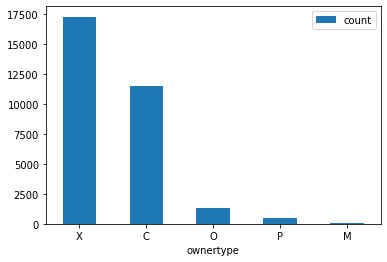

In [8]:
ax = df_dist.plot.bar(x='ownertype', y='count', rot=0)

#### City Ownership (OwnerType = 'C')

Ownertype of 'C' indicates city ownership. Select lots marked as city-owned.

In [9]:
city = df['ownertype'] == "C"
df_city = df[city]
all_city = df[city]

In [10]:
all_city[~all_city.ownername.isin(ownername_df.new_value)]

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
44,4.122040e+09,C,QUEENS PUBLIC LIBRARY,0106000020D70800000100000001030000000100000007...,701550.0,701550.0,P8,08
63,3.020390e+09,C,BROOKLYN PUBLIC LIBRARY,0106000020D70800000100000001030000000100000005...,602100.0,602100.0,P8,08
243,3.063020e+09,C,BROOKLYN PUBLIC LIBRARY,0106000020D70800000100000001030000000100000007...,1158750.0,1158750.0,P8,08
358,5.000020e+09,C,NEW YORK WHEEL LLC,0106000020D7080000010000000103000000010000003F...,8753400.0,8753400.0,G1,10
456,3.040900e+09,C,BROOKLYN PUBLIC LIBRARY,0106000020D70800000100000001030000000100000005...,1146150.0,1146150.0,P8,08
...,...,...,...,...,...,...,...,...
30189,4.110620e+09,C,QUEENS PUBLIC LIBRARY,0106000020D70800000100000001030000000100000005...,791550.0,791550.0,P8,08
30205,1.020240e+09,C,ARMSTRONG'S POINT LLC,0106000020D70800000100000001030000000100000005...,5850.0,0.0,V1,11
30308,1.001280e+09,C,THE BANK OF NEW YORK MELLON,0106000020D70800000100000001030000000100000018...,101500000.0,0.0,O4,05
30503,1.015060e+09,C,CITY UNIVERSITY OF NEW YORK,0106000020D70800000100000001030000000100000005...,60577650.0,60577650.0,W1,08


For lots marked as owned by the city, what is the distribution of building class types (using first position only)?

In [11]:
city_bldgclass_counts = all_city['bldgclass'].str.slice(0, 1).value_counts()
city_bldgclass_counts
city_bldgclass_dist = pd.DataFrame({'bldgclass':city_bldgclass_counts.index, 'count':city_bldgclass_counts.values})
city_bldgclass_dist = pd.merge(city_bldgclass_dist, bldgclass_def, how='left', on=['bldgclass'])
city_bldgclass_dist

,bldgclass,count,descr
0,V,4953,Vacant Land
1,Q,3028,Outdoor Recreation Facilities
2,W,1076,Educational Structures
3,U,509,Utility Bureau Properties
4,Y,453,Selected Government Installations
5,G,389,Garages and Gasoline Stations
6,P,253,Places of Public Assembly and Cultural
7,Z,198,Miscellaneous
8,T,158,Transportation Facilities
9,C,113,Walk-Up Apartments


What's the distribution of city owned properties by landuse code?

In [12]:
city_landuse_counts = all_city['landuse'].value_counts()
city_landuse_counts
city_landuse_dist = pd.DataFrame({'landuse':city_landuse_counts.index, 'count':city_landuse_counts.values})
city_landuse_dist = pd.merge(city_landuse_dist, landuse_def, how='left', on=['landuse'])
city_landuse_dist

,landuse,count,def
0,11,4953,Vacant Land
1,09,3055,Open Space and Outdoor Recreation
2,08,1778,Public Facilities and Institutions
3,07,808,Transportation and Utility
4,10,395,Parking Facilities
5,05,130,Commercial and Office
6,02,91,Multi-Family Walkup Buildings
7,04,59,Mixed Residential and Commercial
8,06,57,Industrial and Manufacturing
9,01,35,One and Two Family Buildings


Remove lots that look city related, and produce a CSV of records marked as city-owned, where the ownername doesn't appear to be the city. This was a little manual-intensive and may not be perfect. (Should any of the names listed here be corrected?)

In [13]:
df_city = df_city[~df_city["ownername"].str.contains('CITY OF NEW YORK')]
df_city = df_city[~df_city["ownername"].str.contains('MTA - STATEN ISLAND RAILWAY')]
df_city = df_city[~df_city["ownername"].str.contains('FIRE DEPARTMENT OF NEW YORK')]
df_city = df_city[~df_city["ownername"].str.contains('NEW YORK PUBLIC LIBRARY')]
df_city = df_city[~df_city["ownername"].str.contains('BROOKLYN PUBLIC LIBRARY')]
df_city = df_city[~df_city["ownername"].str.contains('QUEENS PUBLIC LIBRARY')]
df_city = df_city[~df_city["ownername"].str.contains('CITY UNIVERSITY OF NEW YORK')]
df_city = df_city[~df_city["ownername"].str.contains('OFFICE OF THE CHIEF MEDICAL')]
df_city = df_city[~df_city["ownername"].str.contains('HIGHBRIDGE PRESERVATION LLC')]
df_city = df_city[~df_city["ownername"].str.contains('TAXI & LIMOUSINE COMMISSION')]
df_city = df_city[~df_city["ownername"].str.startswith('NYC')]
df_city = df_city[~df_city["ownername"].str.startswith('NEW YORK CITY')]
df_city = df_city[~df_city["ownername"].str.startswith('EAST HARLEM')]
df_city = df_city[~df_city["ownername"].str.startswith('RESTORING COMMUNITIES')]
df_city = df_city[~df_city["ownername"].str.startswith('BROOKLYN BRIDGE PARK')]
df_city = df_city[~df_city["ownername"].str.startswith('BROOKLYN NAVY')]
df_city = df_city[~df_city["ownername"].str.startswith('SO BX')]
df_city = df_city[~df_city["ownername"].str.startswith('IPIS')]
df_city = df_city[~df_city["ownername"].str.startswith('FULTON PK')]
df_city = df_city[["ownername"]]
df_city = df_city.drop_duplicates()
city_results = pd.merge(all_city, df_city, how='inner', on=['ownername'])
city_results.to_csv('../output/city_illogical_ownernames.csv')

#### Tax-Exempt Ownership (OwnerType = 'X')

Owner type of 'X' refers to a property has any owner type, private or public, but is fully tax-exempt. Look for situations where the exempt value does not equal the assessed value.

In [14]:
not_fully_tax_exempt = df[(df['ownertype'] == 'X') & (df['assesstot'] != df['exempttot'])]
not_fully_tax_exempt

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse


Are there any records where the property appears to be fully tax exempt, but the owner type is not 'X'? Does this matter?

In [15]:
fully_tax_exempt = df[(df['ownertype'] != 'X') & (df['assesstot'] == df['exempttot']) & (df['exempttot'] > 0)]
fully_tax_exempt

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
0,3.025080e+09,C,NYC DEPARTMENT OF SANITATION,0106000020D70800000200000001030000000100000008...,14411700.0,14411700.0,Y6,07
14,1.020290e+09,C,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000007...,382500.0,382500.0,Q1,09
20,3.087610e+09,C,FIRE DEPARTMENT OF NEW YORK,0106000020D70800000100000001030000000100000005...,571050.0,571050.0,Y1,08
21,3.014750e+09,C,NYC HOUSING PRESERVATION AND DEVELOPMENT,0106000020D70800000100000001030000000100000006...,105300.0,105300.0,Q9,09
25,5.064230e+09,C,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000005...,3600.0,3600.0,Q0,09
...,...,...,...,...,...,...,...,...
30724,1.003870e+09,O,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000005...,859500.0,859500.0,G7,10
30727,1.018390e+09,C,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000006...,218700.0,218700.0,Q9,09
30729,3.083930e+09,C,NYC DEPARTMENT OF EDUCATION,0106000020D70800000100000001030000000100000013...,8138250.0,8138250.0,W1,08
30739,3.009550e+09,C,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000007...,17880.0,17880.0,V0,11


Get a distribution of tax exempt properties where the owner type is not 'X'

In [16]:
fte_counts = fully_tax_exempt['ownertype'].value_counts()
fte_counts
fte_dist = pd.DataFrame({'ownertype':fte_counts.index, 'count':fte_counts.values})
fte_dist

,ownertype,count
0,C,7995
1,O,906
2,P,95
3,M,40


#### Privately Owned Lots (OwnerType = 'P')

Is there any reason why something should be marked as privately owned when the ownername matches a value on the ownernames dataframe?

In [17]:
private = df['ownertype'] == "P"
df_private = df[private]
df_private.head()

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
40,3.012960e+09,P,MONT.ROGERS REALTY LLC,0106000020D70800000100000001030000000100000005...,353700.0,0.0,W9,08
46,2.027650e+09,P,GEORGE HOFFMANN,0106000020D70800000100000001030000000100000019...,2569050.0,0.0,G1,10
48,4.026560e+09,P,ELMWEIR CEM ASSN,0106000020D70800000100000001030000000100000008...,298800.0,0.0,G7,10
139,3.022760e+09,P,GREGG BLAINE REALTY CO,0106000020D7080000010000000103000000010000000B...,1479600.0,0.0,I9,08
255,3.039520e+09,P,CYPRESS HILLS COMMUNITY SCHOOL DEVELOPME NT CO...,0106000020D70800000100000001030000000100000006...,2188350.0,0.0,W1,08


In [18]:
df_private[df_private.ownername.isin(ownername_df.new_value)]

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
773,1.020120e+09,P,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000006...,535050.0,535050.0,C1,02
4852,1.008690e+09,P,NEW YORK PUBLIC LIBRARY,0106000020D7080000010000000103000000010000000B...,36156600.0,36156600.0,P8,08
15434,1.020130e+09,P,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000005...,525150.0,525150.0,C1,02
16202,3.045950e+09,P,CITY OF NEW YORK,0106000020D7080000010000000103000000010000000E...,1907550.0,1907550.0,W1,08
16562,5.076640e+09,P,NYS DEPARTMENT OF ENVIRONMENTAL CONSERVATION,0106000020D70800000100000001030000000100000048...,20847150.0,20847150.0,N2,08
17737,1.002200e+09,P,PORT AUTHORITY OF NY AND NJ,0106000020D70800000100000001030000000100000005...,831600.0,831600.0,Q9,09
22350,4.135490e+09,P,CITY OF NEW YORK,0106000020D70800000100000001030000000100000005...,292950.0,292950.0,P8,08
28994,2.023590e+09,P,NYCHA TRIBOROUGH PRESERVATION HDFC,0106000020D70800000100000001030000000100000006...,6191100.0,6191100.0,D6,04


#### OwnerType 'Other' (OwnerType = 'O')

An owner type of 'O' means that the lot is owned by a public authority, the state, or the federal government. Are there records marked as other that have ownernames not on the ownernames table?

In [19]:
other = df['ownertype'] == "O"
df_other = df[other]
df_other.head()

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
43,2.026310e+09,O,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000005...,516600.0,516600.0,Q1,09
62,4.110990e+09,O,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000006...,31860.0,22104.0,A1,01
70,2.029620e+09,O,JENNINGS TERRACE GARDENS HDFC,0106000020D70800000100000001030000000100000007...,272250.0,0.0,C6,02
92,3.037600e+09,O,NYC HOUSING AUTHORITY,0106000020D70800000100000001030000000100000005...,19661400.0,19661400.0,D3,03
98,3.005330e+09,O,NYC HOUSING AUTHORITY,0106000020D7080000010000000103000000010000000A...,16051050.0,16051050.0,D3,03


In [20]:
df_other = df_other[~df_other.ownername.isin(ownername_df.new_value)]
df_other

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
70,2.029620e+09,O,JENNINGS TERRACE GARDENS HDFC,0106000020D70800000100000001030000000100000007...,272250.0,0.0,C6,02
210,3.042580e+09,O,NYS OPWDD,0106000020D70800000100000001030000000100000005...,124200.0,124200.0,G7,10
272,4.126680e+09,O,"LITTLE, GLORIA",0106000020D70800000100000001030000000100000006...,24360.0,0.0,A2,01
571,4.110380e+09,O,HABITAT QUEENS PHASE II HOUSING DEVELOPM ENT FUND,0106000020D70800000100000001030000000100000005...,29640.0,25869.0,A1,01
713,4.103720e+09,O,"ALSTON, MARY",0106000020D70800000100000001030000000100000006...,33900.0,0.0,A1,01
...,...,...,...,...,...,...,...,...
30589,4.119790e+09,O,"IVY, IRENE",0106000020D70800000100000001030000000100000005...,25860.0,8239.0,A1,01
30590,4.117741e+09,O,"WU, GORDAN",0106000020D70800000100000001030000000100000006...,29220.0,13992.0,A1,01
30640,4.127730e+09,O,"GALAN, LUZ ESTHER",0106000020D70800000100000001030000000100000006...,26160.0,0.0,A2,01
30675,4.002780e+09,O,DASNY,0106000020D70800000100000001030000000100000005...,18561600.0,18561600.0,W6,08


What are the building class codes for 'other' types where the owner name is not on the ownernames dataframe?

In [21]:
other_bldgclass_counts = df_other['bldgclass'].str.slice(0, 1).value_counts()
other_bldgclass_dist = pd.DataFrame({'bldgclass':other_bldgclass_counts.index, 'count':other_bldgclass_counts.values})
other_bldgclass_dist = pd.merge(other_bldgclass_dist, bldgclass_def, how='left', on=['bldgclass'])
other_bldgclass_dist

,bldgclass,count,descr
0,A,85,One Family Dwellings
1,W,43,Educational Structures
2,C,18,Walk-Up Apartments
3,D,16,Elevator Apartments
4,G,14,Garages and Gasoline Stations
5,V,12,Vacant Land
6,B,8,Two Family Dwellings
7,Q,8,Outdoor Recreation Facilities
8,O,5,Office Buildings
9,I,3,Hospitals and Health


And the landuse codes?

In [22]:
other_landuse_counts = df_other['landuse'].value_counts()
other_landuse_dist = pd.DataFrame({'landuse':other_landuse_counts.index, 'count':other_landuse_counts.values})
other_landuse_dist = pd.merge(other_landuse_dist, landuse_def, how='left', on=['landuse'])
other_landuse_dist

,landuse,count,def
0,01,93,One and Two Family Buildings
1,08,50,Public Facilities and Institutions
2,02,15,Multi-Family Walkup Buildings
3,10,14,Parking Facilities
4,03,13,Multi-Family Elevator Buildings
5,11,12,Vacant Land
6,09,8,Open Space and Outdoor Recreation
7,05,6,Commercial and Office
8,04,6,Mixed Residential and Commercial
9,07,5,Transportation and Utility


#### Mixed Ownership (OwnerType = 'M')

There aren't very many lots with mixed ownership. Which ones have an ownername that isn't on the ownernames table?

In [23]:
mixed = df['ownertype'] == "M"
df_mixed = df[mixed]
df_mixed.head()

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
1456,4.154811e+09,M,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D70800000100000001030000000100000007...,673650.0,673650.0,P8,08
2002,5.052120e+09,M,NYC DEPARTMENT OF PARKS AND RECREATION,0106000020D7080000010000000103000000010000009E...,460350.0,460350.0,Q1,09
2574,5.051330e+09,M,B WOODRUFF,0106000020D7080000010000000103000000010000003A...,33480.0,4800.0,A2,01
2854,3.006250e+09,M,HOME DEPOT U S A INC,0106000020D70800000100000001030000000100000012...,20186550.0,4392720.0,K8,05
2967,5.051440e+09,M,UNITED BRETHRENS CH-S I,0106000020D70800000100000001030000000100000016...,1040850.0,1040850.0,M1,08


In [24]:
df_mixed_no_ownername = df_mixed[~df_mixed.ownername.isin(ownername_df.new_value)]
df_mixed_no_ownername

,bbl,ownertype,ownername,geom,assesstot,exempttot,bldgclass,landuse
2574,5.051330e+09,M,B WOODRUFF,0106000020D7080000010000000103000000010000003A...,33480.0,4800.0,A2,01
2854,3.006250e+09,M,HOME DEPOT U S A INC,0106000020D70800000100000001030000000100000012...,20186550.0,4392720.0,K8,05
2967,5.051440e+09,M,UNITED BRETHRENS CH-S I,0106000020D70800000100000001030000000100000016...,1040850.0,1040850.0,M1,08
3630,4.059170e+09,M,NYC FIRE DEPARTMENT,0106000020D70800000300000001030000000100000034...,65554650.0,65554650.0,Y1,08
4187,4.078800e+09,M,CREEDMOOR STATE HOSPITAL,0106000020D70800000100000001030000000100000052...,114475500.0,114475500.0,I1,08
4982,5.069010e+09,M,WARINGIN LTD,0106000020D7080000010000000103000000010000000E...,9780.0,0.0,V0,11
6734,4.093580e+09,M,PINNACLE TOO LLC,0106000020D70800000100000001030000000100000008...,261900.0,0.0,F1,06
7047,1.007760e+09,M,DORMITORY AUTHORITYNYS,0106000020D70800000100000001030000000100000007...,12977100.0,12977100.0,H8,08
7107,4.084010e+09,M,NYC PARK DEPT,0106000020D70800000100000001030000000100000028...,9359100.0,9359100.0,V1,11
8206,4.159050e+09,M,BENJAMIN BECHWOOD DUNES LLC,0106000020D7080000010000000103000000010000000C...,58140.0,0.0,V0,11


#### Unknown Ownership (OwnerType IS NULL)

Are there any unknown owner types with an ownername on the ownernames dataframe? I don't know if there is any interest in setting the owner type based on the ownername value.

In [ ]:
df_unknown = pd.read_sql_query('''SELECT * FROM dcp.pluto201 WHERE ownertype IS NULL;''', cnx)
df_unknown = df_unknown[["bbl", "ownertype", "ownername", "geom", "assesstot", "exempttot", "bldgclass", "landuse"]]
df_unknown.head()

In [ ]:
df_unknown_on_ownernames = df_unknown[df_unknown.ownername.isin(ownername_df.new_value)]
df_unknown_on_ownernames

Are there any ownername values that are equal to old_value on the ownernames dataframe?

In [ ]:
df_old_ownername = pd.read_sql_query('''SELECT * FROM dcp.pluto201 
WHERE ownername IN (SELECT DISTINCT old_value FROM dcp.ownernames);''', cnx)
df_old_ownername = df_old_ownername[["bbl", "ownertype", "ownername", "geom", "assesstot", "exempttot", "bldgclass", "landuse"]]
df_old_ownername.head()